In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.constants as const
import seaborn as sns

In [2]:
%matplotlib notebook

In [22]:
def Create_dataframes(filenames, directory, row_label):
    dataframes = {}
    for name in filenames:
        file_directory = f'{directory}/{name}.csv'
        data = pd.read_csv(file_directory, index_col=row_label)
        dataframes[name] = data
    return dataframes

def Ensure_all(All_variables):
    no_nan_tables = [table.dropna() for table in All_variables]
    
    num_variables = len(no_nan_tables)
    previous_merge = no_nan_tables[0]
    for index in range(1, num_variables):
        current_table = no_nan_tables[index]
        previous_merge = pd.merge(previous_merge, current_table, left_index=True, right_index=True, how='inner')
    return previous_merge

def Remove_rejects(All_variables, rejected_IDs):
    for variable_table in All_variables:
            variable_table.drop(rejected_IDs, inplace=True)
            
def Create_HR(dataframes, Teff_source, Rad_source):
    Teff_dataframe = dataframes[Teff_source]['Teff']
    Radius_dataframe = dataframes[Rad_source]['Radius']
    
    Total_data = [Teff_dataframe, Radius_dataframe]
    Filtered_data = Ensure_all(Total_data)
    Teff = Filtered_data['Teff']
    Radius = Filtered_data['Radius']
    
    Luminosity = Radius**2*(Teff/5772)**4
    return Teff, Luminosity

def Split_errors(database, variable_name, error_prefix=None, keep_columns=None):
    if error_prefix is None:
        error_prefix = variable_name
    try:
        if keep_columns is None:
            data = database[[f'{variable_name}', f'{error_prefix} pe', f'{error_prefix} me']]
        else:
            data = database[[f'{variable_name}', f'{error_prefix} pe', f'{error_prefix} me', *keep_columns]]
    except KeyError:
        half_pme = database[f'{error_prefix} pme']/2
        pe = half_pme.rename(f'{error_prefix} pe')
        me = half_pme.rename(f'{error_prefix} me')
        if keep_columns is None:
            data = database[f'{variable_name}']
        else:
            data = database[[f'{variable_name}', *keep_columns]]
            
        data = pd.merge(data, pe, left_index=True, right_index=True)
        data = pd.merge(data, me, left_index=True, right_index=True)
    return data

def Largest_error(errors, error_prefix):
    pe_column = f'{error_prefix} pe'
    me_column = f'{error_prefix} me'

    largest_errors = np.maximum(errors[pe_column], errors[me_column])

    return largest_errors

def Create_valley(starframes, planetframes, X_variable, X_error_prefix, X_source, PSR_source, Host_radii_source):
        
    #Checking for split errors
    PSR_data = Split_errors(planetframes[PSR_source], 'PSR')
    
    #Checking for split errors
    Host_Radii_dataframe = Split_errors(starframes[Host_radii_source], 'Radius', 'Rad')
    
    if 'Planets' in X_source:
        X_data = Split_errors(planetframes[X_source], X_variable, keep_columns=['Host Gaia DR3 ID'])
        Planet_data = [X_data, PSR_data]
        Planet_dataframe = Ensure_all(Planet_data).set_index('Host Gaia DR3 ID')
        Total_data = [Planet_dataframe, Host_Radii_dataframe]
    else:
        X_data = Split_errors(planetframes[X_source], X_variable)
        Planet_dataframe = PSR_data.set_index('Host Gaia DR3 ID')
        Total_Data = [Planet_dataframe, Host_Radii_dataframe, X_data]
    
    #Filtering out sources with no data and combining the dataframes
    Filtered_data = Ensure_all(Total_data)
    
    X = Filtered_data[X_variable]
    X_err = Filtered_data[[f'{X_error_prefix} pe', f'{X_error_prefix} me']]
    
    PSR = Filtered_data['PSR']
    PSR_err = Largest_error(Filtered_data, 'PSR')
    
    Host_Radii = Filtered_data['Radius']
    Host_Radii_err = Largest_error(Filtered_data, 'Rad')
    
    Sun_Earth = const.R_sun/const.R_earth
    Planet_Radii = PSR*Host_Radii*Sun_Earth
    Planet_Radii_err = Sun_Earth*np.sqrt(Host_Radii**2*PSR_err**2 + PSR**2*Host_Radii_err**2)
        
    return X, X_err, Planet_Radii, Planet_Radii_err

In [4]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
#Main_directory = 'C:/Users/georg/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
All_stars_directory = f'{Main_directory}/Sorted Data/Stars'
All_planets_directory = f'{Main_directory}/Sorted Data/Planets'

star_filenames = ['Gaia All Stars', 'Exo All Stars', 'Fulton All Stars', 'VanEylen All Stars', 'BASTA All Stars']
planet_filenames = ['HoVan All Planets', 'Fulton All Planets', 'VanEylen All Planets', 'Exo All Planets']

starframes = Create_dataframes(star_filenames, All_stars_directory, 'Gaia DR3 ID')
planetframes = Create_dataframes(planet_filenames, All_planets_directory, 'KOI')

<IPython.core.display.Javascript object>


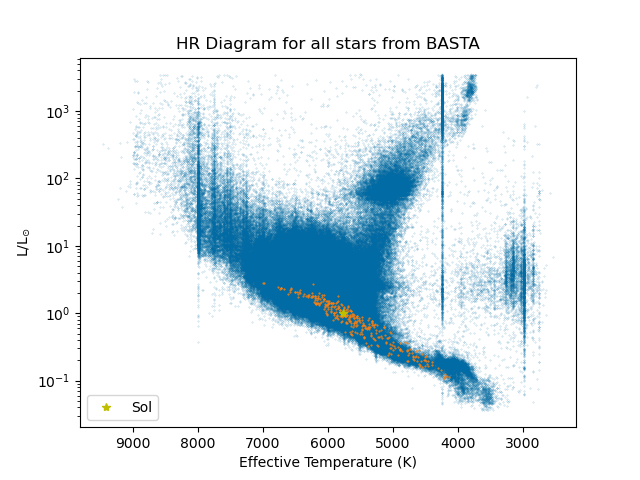

In [5]:
Dataset1 = 'Gaia All Stars'
Dataset2 = 'BASTA All Stars'

Teff, Luminosity = Create_HR(starframes, Dataset1, Dataset2)

HR_data = pd.read_csv(f'{Main_directory}/Raw Data/HR Data (Flags).csv')
def Gaia_flag(flag, wanted_flag):
    if flag != wanted_flag:
        flag = None
    return flag

HR_data['flags_flame'] = HR_data['flags_flame'].apply(Gaia_flag, args=[0])
HR_data.dropna(inplace=True)

Title = 'HR Diagram for all stars from BASTA'
Colour = plt.style.use('tableau-colorblind10')

plt.figure()
plt.plot(HR_data['teff_gspspec'], HR_data['lum_flame'], '.', color=Colour, markersize=0.5, alpha=0.4)
plt.plot(Teff, Luminosity, '.', color=Colour, markersize=1)
plt.plot(5772, 1, 'y*', label='Sol')
plt.ylabel('L/L$_{\odot}$')
plt.xlabel('Effective Temperature (K)')
plt.title(Title)
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()
#plt.savefig(f'{Main_directory}/Plots/{Title} - 2')

In [6]:
def Gradienter(XAxis, YAxis, m, X=10):
    NewX = np.linspace(10, 10, len(XAxis))
    NewY = m*(np.log10(X)-np.log10(XAxis))+YAxis
    return NewX, NewY

In [7]:
def Bins(DataX, DataY, NoBins, Graph=False):
    
    Frequency = np.sort(np.array(DataY)) # Axis to be binned
    Power = np.array(DataX) # Height of bin

    Range = int(len(Frequency)/NoBins) # Number of points in each bin
    n = 0
    NewPower = []
    NewFrequency = []
    while n < len(Frequency)-Range:
        Total = len(Power[n:n+Range])
        f = (Frequency[n]+Frequency[n+Range])/2
        Width = (Frequency[n+Range]-Frequency[n])
        NewPower.append(Total/Width)
        NewFrequency.append(f)
        n += Range
    
    Noise = NewPower[len(NewPower)//2:]
    MeanNoise = np.mean(Noise)
    Threshold = 2*np.std(Noise) + MeanNoise
    
    if Graph:
        plt.figure()
        plt.bar(NewFrequency, NewPower, width=Width, label='Binned Data')
        #plt.plot([min(NewFrequency), max(NewFrequency)], [MeanNoise, MeanNoise], 'r--')
        #plt.plot([min(NewFrequency), max(NewFrequency)], [Threshold, Threshold], 'g--')
        plt.xlabel(r'R/R$_{\odot}$')
        plt.ylabel('Frequency')
        plt.title('Binned Spectrum')
        plt.show()

    return NewFrequency, NewPower

In [8]:
def ValleyFinder(Bin, Height):
    BinList = []
    HeightList = []
    for b in range(len(Bin)):
        if Bin[b] > 1 and Bin[b] < 3:
            BinList.append(Bin[b])
            HeightList.append(Height[b])

    MinHeight = min(HeightList)
    MinIndex = HeightList.index(MinHeight)
    Minimum = BinList[MinIndex]
    return Minimum, MinHeight

In [18]:
P_dataset = 'Exo All Planets'
PSR_dataset = 'Exo All Planets'
Host_dataset = 'Gaia All Stars'

P, P_err, Planet_Radii, Planet_Radii_err = Create_valley(starframes, planetframes, 'P', 'P', P_dataset, PSR_dataset, Host_dataset)

In [10]:
Gradients = np.linspace(-0.21, -0.1, 1000)
MinimumList = []
MinHeightList = []
for g in range(len(Gradients)):
    Bin, Height = Bins(*Gradienter(P, Planet_Radii, Gradients[g]), 20)
    Minimum, MinHeight = ValleyFinder(Bin, Height)
    MinimumList.append(Minimum)
    MinHeightList.append(MinHeight)

In [11]:
Index = MinHeightList.index(min(MinHeightList))
RadiusValley = MinimumList[Index]
Gradient = Gradients[Index]
c = np.log10(RadiusValley) - Gradient*np.log10(10)
print(RadiusValley)
print(Gradient)

2.580981744678093
-0.18555555555555556


<IPython.core.display.Javascript object>


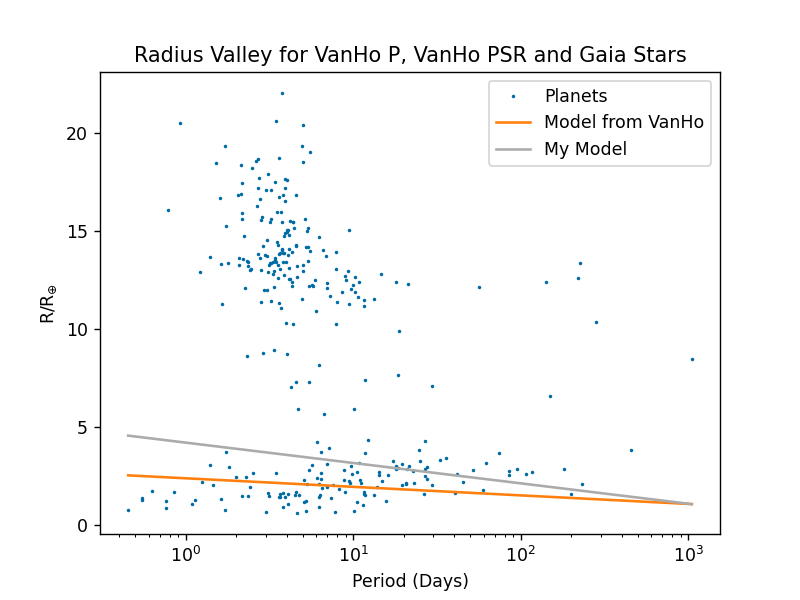

In [19]:
x = np.linspace(min(P), max(P), 2)
m1 = -0.11
c1 = 0.37
y1 = 10**(m1*np.log10(x) + c1)
y2 = 10**(Gradient*np.log10(x) + c)

Title = 'Radius Valley for VanHo P, VanHo PSR and Gaia Stars'
Colour = plt.style.use('tableau-colorblind10')

plt.figure()
plt.plot(P, Planet_Radii, '.', color=Colour, markersize=2, label='Planets')
plt.plot(x, y1, color=Colour, label='Model from VanHo')
plt.plot(x, y2, color=Colour, label='My Model')
#plt.plot(365, 1, 'b.', label='Earth')
plt.xscale('log')
plt.xlabel('Period (Days)')
plt.ylabel('R/R$_{\oplus}$')
plt.title(Title)
plt.legend()
plt.show()
#plt.savefig(f'{Main_directory}/Plots/{Title} - 2')